In [1]:
import os
import json
import collections
from pathlib import Path

import numpy as np
from scipy import interpolate, integrate

from tqdm.notebook import tqdm

from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
visualization.quantity_support()
from astropy import units as u
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import StdDevUncertainty

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from jwst import datamodels

import webbpsf

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
data_dir = Path('widened_2')
for nm in data_dir.iterdir():
    print(nm)

widened_2/jw02609009001_04101_00001_nrs1_interpolatedflat.fits
widened_2/jw02609009001_04101_00001_nrs1_cal.fits
widened_2/jw02609009001_04101_00001_nrs2_interpolatedflat.fits
widened_2/jw02609009001_04101_00001_nrs2_cal.fits
widened_2/jw02609009001_04103_00001_nrs1_interpolatedflat.fits
widened_2/jw02609009001_04103_00001_nrs1_cal.fits
widened_2/jw02609009001_04103_00001_nrs2_interpolatedflat.fits
widened_2/jw02609009001_04103_00001_nrs2_cal.fits
widened_2/jw02609009001_04105_00001_nrs1_interpolatedflat.fits
widened_2/jw02609009001_04105_00001_nrs1_cal.fits
widened_2/jw02609009001_04105_00001_nrs2_interpolatedflat.fits
widened_2/jw02609009001_04105_00001_nrs2_cal.fits
widened_2/jw02609009001_04107_00001_nrs1_interpolatedflat.fits
widened_2/jw02609009001_04107_00001_nrs1_cal.fits
widened_2/jw02609009001_04107_00001_nrs2_interpolatedflat.fits
widened_2/jw02609009001_04107_00001_nrs2_cal.fits
widened_2/jw02609009001_04109_00001_nrs1_interpolatedflat.fits
widened_2/jw02609009001_04109_000

In [3]:
test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

In [4]:
test_dm = datamodels.open(test_path)
test_dm

<MultiSlitModel from jw02609009001_04101_00001_nrs2_cal.fits>

In [5]:
example_slit = test_dm.slits[50]

2023-03-04 04:20:56,333 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/asdf/tags/core/ndarray.py:563: RuntimeWarning: invalid value encountered in divide
  return getattr(self._make_array(), name)(*args)



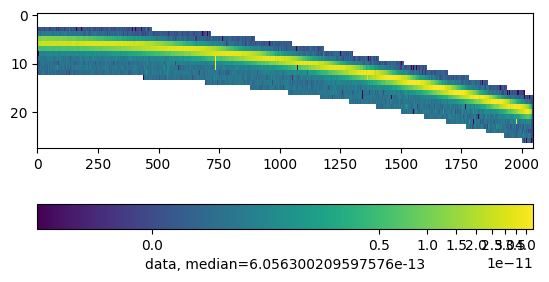

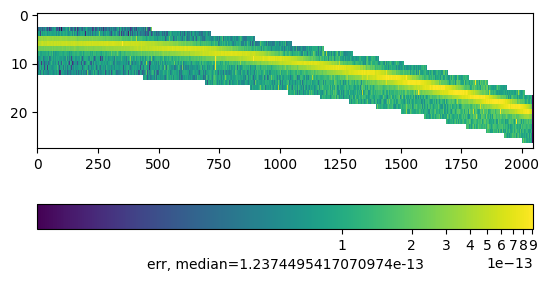

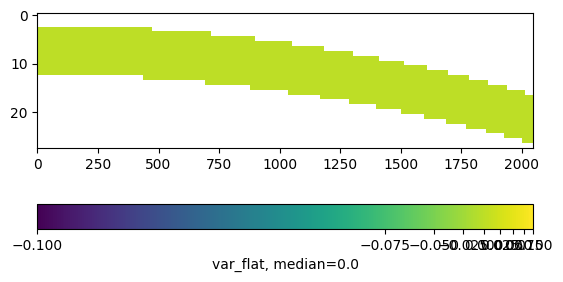

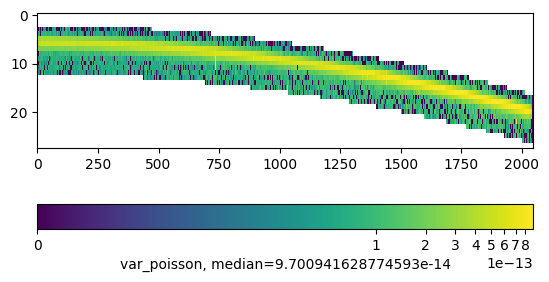

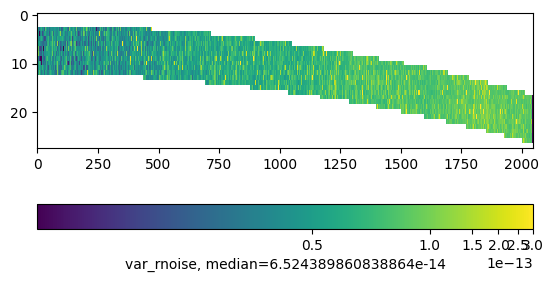

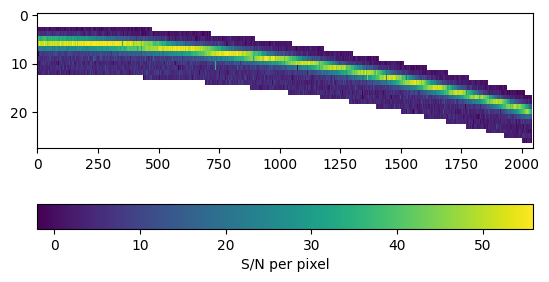

In [6]:
for attrnm in ['data', 'err'] + [nm for nm in example_slit if nm.startswith('var')]:
    plt.figure()
    arr = getattr(example_slit, attrnm)
    if attrnm.startswith('var'):
        arr = arr**0.5
    visualization.imshow_norm(arr, aspect=20,
                              interval=visualization.PercentileInterval(99),
                              stretch=visualization.LogStretch(),
                              interpolation='nearest'
                             )
    plt.colorbar(orientation='horizontal').set_label(f'{attrnm}, median={np.median(arr[np.isfinite(arr)])}')

plt.figure()
visualization.imshow_norm(example_slit.data / example_slit.err, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal').set_label(f'S/N per pixel')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f2c29303390>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2c22c7e290>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2c2cbd68d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2c2d3817d0>]

It seems a bit weird that the flat has *no* error, but I looked at the flats and they  also have all zero errors... 🤷

So lets take the err at face value for now, and try "extracting" a spectrum by distribution-building:

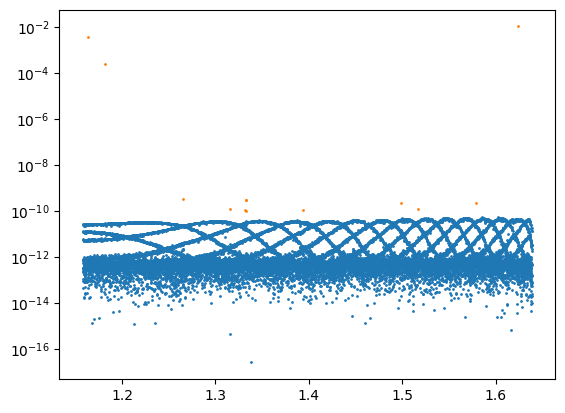

In [7]:
msk = np.isfinite(example_slit.wavelength) & np.isfinite(example_slit.data)
wl = example_slit.wavelength[msk]
d = example_slit.data[msk]

clip_msk = sigma_clip(d, maxiters=3, sigma=4).mask

plt.semilogy(wl[~clip_msk], d[~clip_msk], '.',ms=2)
plt.semilogy(wl[clip_msk], d[clip_msk], '.',ms=2)

sorti = np.argsort(wl[~clip_msk])
wl2 = wl[~clip_msk][sorti]
d2 = d[~clip_msk][sorti]

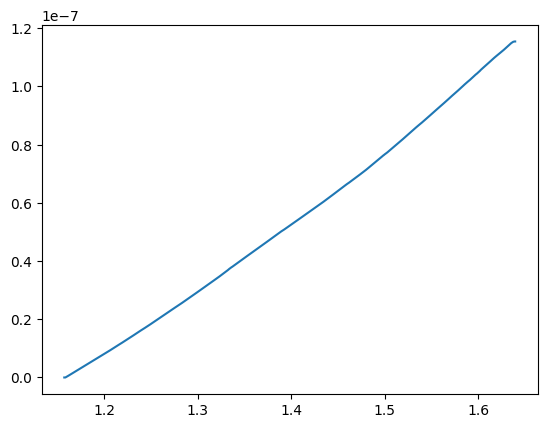

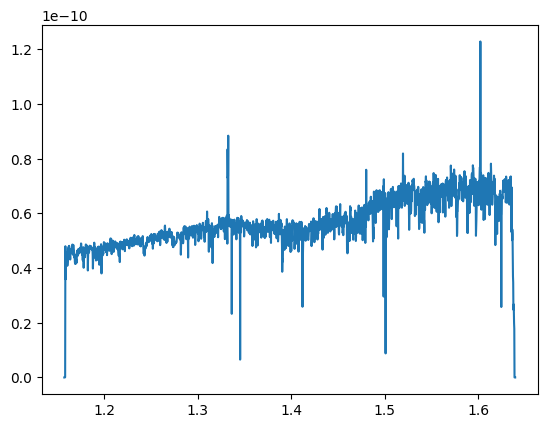

In [8]:
bins = np.linspace(np.min(wl2), np.max(wl2), 2048)
midbins = (bins[:-1] + bins[1:])/2

plt.plot(bins, np.interp(bins, wl2, np.cumsum(d2)))

plt.figure()
diffspec = np.diff(np.interp(bins, wl2, np.cumsum(d2)))
plt.plot(midbins, diffspec)

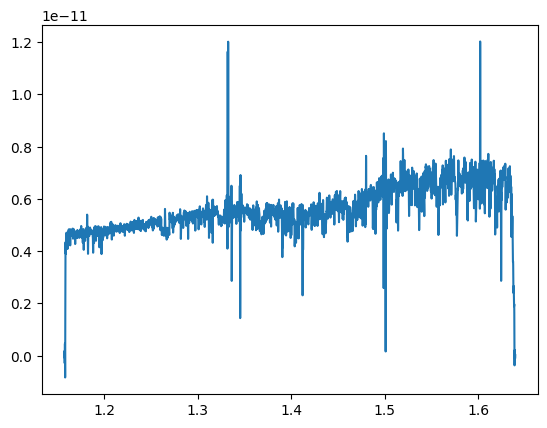

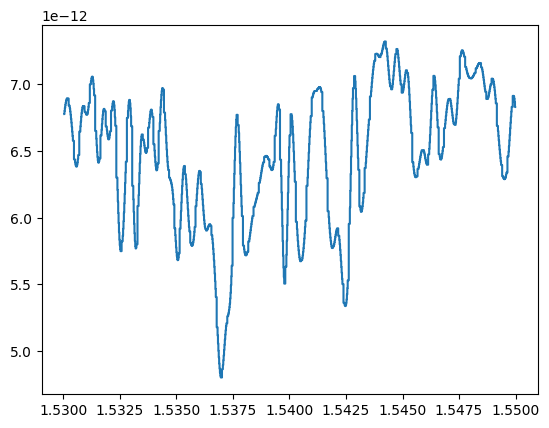

In [9]:
spl = interpolate.LSQUnivariateSpline(wl2, d2, bins[1:-1])
plt.plot(wl2, spl(wl2))
interped_example_spec = specutils.Spectrum1D(spectral_axis=wl2*u.micron, flux=spl(wl2)*u.Unit(example_slit.meta.bunit_data))
binned_example_spec = specutils.Spectrum1D(spectral_axis=wl2*u.micron, flux=spl(wl2)*u.Unit(example_slit.meta.bunit_data))


lower = 1.53
upper = 1.55
zoommsk = (lower<wl2)&(wl2 < upper)

plt.figure()
plt.plot(wl2[zoommsk], spl(wl2[zoommsk]), ds='steps-mid')

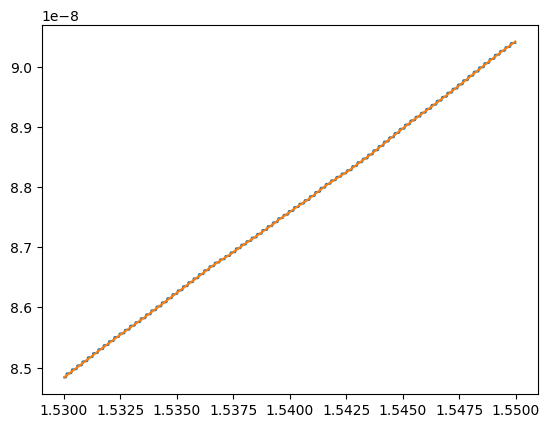

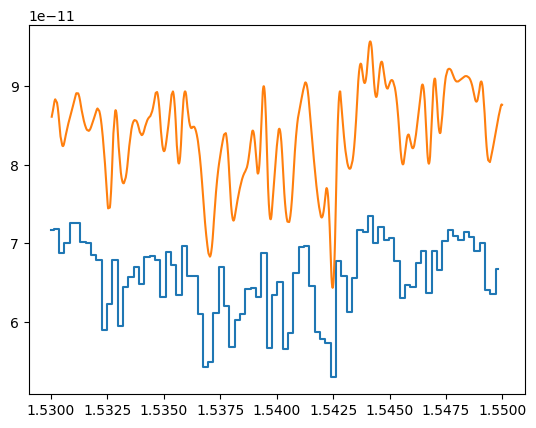

In [10]:
spl = interpolate.LSQUnivariateSpline(wl2, np.cumsum(d2), bins[1:-1])

lower = 1.53
upper = 1.55
zoommsk = (lower<wl2)&(wl2 < upper)

plt.plot(wl2[zoommsk], np.cumsum(d2)[zoommsk])
plt.plot(wl2[zoommsk], spl(wl2[zoommsk]))


plt.figure()

zoommsk_binned = (lower < midbins)&(midbins < upper)
plt.plot(midbins[zoommsk_binned], diffspec[zoommsk_binned], ds='steps-mid')

plt.plot(wl2[zoommsk], spl.derivative(1)(wl2)[zoommsk]*3e-4)

I guess the spline-fit actually looks pretty reasonable, so it looks like we have a decent spectrum.  Lets load some relevant templates now.

In [11]:
slit_coo = SkyCoord(example_slit.source_ra, example_slit.source_dec, unit=u.deg)

In [12]:
phat_tab = table.QTable.read('hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits')
phat_tab['coord'] = SkyCoord.guess_from_table(phat_tab, unit='deg')

with open('phat_astrom_correction.json') as f:
    phat_astrom_correction = json.load(f)

phat_tab['coord_corr'] = SkyCoord(
    ra=phat_tab['coord'].ra + phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
    dec=phat_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)

x,y,ra,dec,f110w_rate,f110w_raterr,f110w_vega,f110w_err,f110w_chi,f110w_snr,f110w_sharp,f110w_round,f110w_crowd,f110w_flag,f160w_rate,f160w_raterr,f160w_vega,f160w_err,f160w_chi,f160w_snr,f160w_sharp,f160w_round,f160w_crowd,f160w_flag,f275w_rate,f275w_raterr,f275w_vega,f275w_err,f275w_chi,f275w_snr,f275w_sharp,f275w_round,f275w_crowd,f275w_flag,f336w_rate,f336w_raterr,f336w_vega,f336w_err,f336w_chi,f336w_snr,f336w_sharp,f336w_round,f336w_crowd,f336w_flag,f475w_rate,f475w_raterr,f475w_vega,f475w_err,f475w_chi,f475w_snr,f475w_sharp,f475w_round,f475w_crowd,f475w_flag,f814w_rate,f814w_raterr,f814w_vega,f814w_err,f814w_chi,f814w_snr,f814w_sharp,f814w_round,f814w_crowd,f814w_flag,f275w_gst,f336w_gst,f475w_gst,f814w_gst,f110w_gst,f160w_gst,field,ir_x,ir_y,inside_ir,inside_brick,inside_chipgap,inside_other_chipgap,coord,coord_corr
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg","deg,deg"
float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,bool,bool,bool,bool,bool,int64,float32,float32,bool,bool,bool,bool,SkyCoord,SkyCoord
1274.38,2450.39,11.579357043152323,42.11034257945481,1.54e-08,3.28e-11,19.534,0.002,0.82,467.9,0.013,0.009,0.095,0,4.3e-08,7.32e-11,18.417,0.002,0.67,587.1,-0.001,-0.007,0.081,0,-2.9e-11,1.89e-11,99.999,9.999,1.0,-1.5,0.0,0.0,0.0,0,1.23e-12,7.4e-12,29.771,6.408,1.02,0.2,0.468,-0.884,0.008,2,4.7e-11,1.89e-12,25.82,0.043,1.15,25.0,0.035,0.427,0.053,0,3.19e-09,1.4e-11,21.242,0.005,0.68,228.7,-0.009,0.009,0.025,0,True,False,True,True,True,True,1,408.18317,822.43384,True,True,False,False,"11.579357043152323,42.11034257945481","11.579390223860297,42.11033755562654"
1271.11,2450.69,11.579316591687517,42.1103769289951,5.4e-10,1.59e-11,23.169,0.032,6.56,33.9,-0.042,0.344,1.988,0,9.95e-10,4.02e-11,22.506,0.044,4.36,24.8,-0.019,0.236,2.85,0,5.65e-12,1.98e-11,28.12,3.629,1.03,0.3,1.095,9.999,0.0,0,2.92e-12,6.91e-12,28.838,2.614,0.91,0.4,-0.22,-0.023,0.015,0,-1.1e-12,1.32e-12,99.999,0.052,1.1,-1.5,1.175,3.982,1.93,0,-2e-12,3.97e-12,99.999,0.023,1.55,-1.0,0.279,0.239,6.368,0,False,False,True,True,True,False,1,407.39856,823.4718,True,True,False,False,"11.579316591687517,42.1103769289951","11.579349772395492,42.110371905166836"
1278.71,2450.94,11.579396244304327,42.1102893898048,2.61e-09,1.85e-11,21.459,0.008,6.87,141.2,0.035,0.07,0.638,0,5.26e-09,4.12e-11,20.697,0.008,2.78,127.8,0.045,0.054,0.968,0,-2.5e-11,1.89e-11,99.999,1.236,1.05,-1.3,4.098,9.999,0.001,0,5.8e-12,7.39e-12,28.091,1.377,1.16,0.8,1.282,0.137,0.009,0,1.2e-10,2.32e-12,24.805,0.021,1.12,51.6,-0.105,0.194,0.019,0,1.27e-09,9.73e-12,22.24,0.008,1.83,131.6,-0.055,0.042,0.125,0,True,False,True,True,True,True,1,409.46677,821.338,True,True,False,False,"11.579396244304327,42.1102893898048","11.579429425012302,42.11028436597653"
1269.24,2446.92,11.579353224127548,42.11042865980895,8.78e-11,9.28e-12,25.142,0.115,2.35,9.5,-0.106,-0.369,2.288,0,1.11e-10,2.23e-11,24.889,0.219,2.33,5.0,0.155,-0.269,5.291,0,8.76e-12,1.98e-11,27.644,2.705,1.06,0.4,-0.05,0.376,0.001,0,2.29e-11,7.7e-12,26.598,0.363,0.86,3.0,0.3,0.367,0.003,0,-1.8e-12,1.07e-12,99.999,0.095,1.35,-1.7,0.0,0.0,0.0,0,-4.4e-12,3.09e-12,99.999,0.094,1.25,-1.7,3.527,1.909,8.481,0,False,False,True,True,False,False,1,405.9313,822.906,True,True,False,False,"11.579353224127548,42.11042865980895","11.579386404835523,42.11042363598069"
1280.23,2445.69,11.579492539235414,42.1103150514147,3.52e-10,1.07e-11,23.633,0.033,3.35,33.0,0.134,0.249,1.033,0,5.41e-10,2.53e-11,23.167,0.051,2.41,21.4,0.044,-0.028,1.696,2,4.67e-11,2.13e-11,25.827,0.499,0.93,2.2,-0.

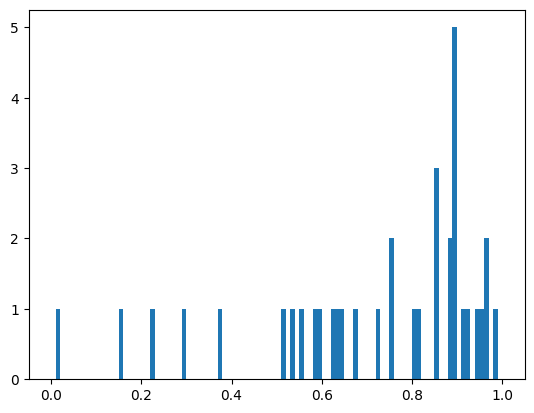

In [13]:
sep = slit_coo.separation(phat_tab['coord_corr'])

plt.hist(sep.arcsec, range=(0, 1), bins=100);
matches_phat_tab = phat_tab[np.argsort(sep)[:5]]
matches_phat_tab

In [14]:
beast_tab = table.Table.read('b19_stats_toothpick_v1.1.fits')
beast_tab['coord'] = SkyCoord.guess_from_table(beast_tab, unit=u.deg)

In [15]:
sepb = matches_phat_tab[0]['coord'].separation(beast_tab['coord'])
sepb[np.argsort(sepb)].marcsec

array([2.44150466e+00, 2.16631900e+02, 3.75398811e+02, ...,
       7.07407238e+05, 7.07410996e+05, 7.07700255e+05])

Clearly the top one is the match.  Just including others for sanity-checking

In [16]:
matches_beast_tab = beast_tab[np.argsort(sepb)][:5]
matches_beast_tab

M_act_Exp,Pmax,logHST_WFC3_F160W_nd_p50,mbol_Best,logHST_WFC3_F160W_nd_p16,Rv_p84,logF_QION_wd_p84,logGALEX_NUV_wd_p50,logL_p84,logHST_WFC3_F110W_wd_p84,logHST_WFC3_F110W_nd_Best,logF_UV_6_13e_wd_p50,logGALEX_FUV_nd_p50,M_ini_Best,logF_QION_wd_p16,logF_UV_6_13e_nd_p50,RA,M_act_p16,logL_p16,f_A_Best,logGALEX_NUV_wd_Exp,Av_Best,HST_WFC3_F275W,logT_p16,Rv_A_Exp,radius_p50,mbol_p16,logF_QION_nd_p50,logF_QION_wd_Best,logHST_WFC3_F110W_wd_p16,logHST_WFC3_F110W_nd_p16,logHST_ACS_WFC_F814W_wd_p84,logHST_WFC3_F275W_wd_p50,logA_Exp,M_act_p84,logHST_ACS_WFC_F475W_wd_p50,logHST_ACS_WFC_F814W_wd_Best,M_act_Best,Rv_Exp,logF_QION_nd_Exp,Rv_A_p50,logg_p84,logHST_WFC3_F110W_nd_Exp,Z_Best,logT_Exp,HST_WFC3_F336W,logHST_ACS_WFC_F814W_wd_p16,logGALEX_NUV_nd_p16,logGALEX_FUV_nd_Best,logGALEX_FUV_wd_p16,Av_Exp,logHST_WFC3_F336W_wd_p84,logHST_WFC3_F110W_nd_p84,Av_p50,DEC,logF_UV_6_13e_nd_Best,f_A_p50,HST_WFC3_F110W,logGALEX_FUV_wd_p84,logHST_ACS_WFC_F814W_nd_Exp,logGALEX_NUV_nd_Best,logHST_ACS_WFC_F475W_nd_p50,logHST_WFC3_F275W_nd_p50,inside_brick,Z_Exp,logHST_ACS_WFC_F475W_nd_Exp,logg_Exp,logF_UV_6_13e_nd_Exp,logL_p50,M_ini_p84,logGALEX_NUV_wd_p84,logF_QION_wd_Exp,logHST_WFC3_F336W_wd_p16,logHST_WFC3_F160W_wd_p84,logGALEX_NUV_nd_p84,logF_UV_6_13e_wd_Best,logHST_ACS_WFC_F814W_wd_Exp,logF_QION_wd_p50,Rv_p50,logHST_ACS_WFC_F814W_nd_Best,logHST_WFC3_F336W_nd_p84,M_ini_p16,mbol_p84,logHST_ACS_WFC_F814W_nd_p16,logHST_WFC3_F336W_nd_p16,logHST_WFC3_F275W_wd_Exp,logHST_WFC3_F336W_wd_Exp,inside_chipgap,Z_p50,logGALEX_FUV_nd_Exp,logHST_WFC3_F336W_nd_Best,HST_WFC3_F160W,logA_Best,logGALEX_NUV_wd_p16,logT_Best,logHST_ACS_WFC_F814W_nd_p84,logF_UV_6_13e_wd_Exp,M_act_p50,f_A_Exp,logGALEX_NUV_nd_Exp,radius_Best,logHST_WFC3_F160W_wd_Exp,logF_UV_6_13e_nd_p16,logHST_WFC3_F160W_wd_p16,logHST_WFC3_F110W_nd_p50,logHST_WFC3_F110W_wd_p50,logT_p50,Av_p84,radius_p16,Rv_Best,HST_ACS_WFC_F814W,logGALEX_FUV_nd_p84,logF_QION_nd_p16,logHST_ACS_WFC_F475W_nd_p84,logF_UV_6_13e_nd_p84,chi2min_indx,logHST_WFC3_F275W_wd_p16,logHST_WFC3_F160W_wd_Best,logHST_WFC3_F160W_nd_p84,M_ini_Exp,logHST_WFC3_F275W_wd_p84,logA_p84,radius_Exp,logHST_WFC3_F160W_nd_Exp,logF_QION_nd_p84,logGALEX_FUV_nd_p16,logF_QION_nd_Best,logHST_WFC3_F275W_wd_Best,specgrid_indx,logHST_ACS_WFC_F475W_wd_p16,Rv_A_p16,chi2min,logL_Best,logT_p84,logA_p50,logHST_ACS_WFC_F475W_nd_p16,logGALEX_FUV_wd_p50,logF_UV_6_13e_wd_p16,Av_p16,Z_p16,Rv_A_p84,logHST_ACS_WFC_F814W_wd_p50,logGALEX_FUV_wd_Exp,logHST_WFC3_F336W_nd_p50,logHST_WFC3_F336W_wd_p50,logHST_ACS_WFC_F475W_wd_p84,f_A_p16,field,logHST_ACS_WFC_F475W_wd_Exp,logGALEX_FUV_wd_Best,logGALEX_NUV_nd_p50,HST_ACS_WFC_F475W,mbol_p50,logA_p16,logHST_WFC3_F275W_nd_p16,radius_p84,logHST_ACS_WFC_F814W_nd_p50,f_A_p84,Name,logHST_WFC3_F275W_nd_Best,logHST_WFC3_F275W_nd_p84,logGALEX_NUV_wd_Best,logg_p50,logHST_WFC3_F110W_wd_Exp,logHST_ACS_WFC_F475W_wd_Best,Rv_p16,logg_Best,logHST_WFC3_F275W_nd_Exp,logF_UV_6_13e_wd_p84,logHST_WFC3_F336W_wd_Best,Z_p84,logHST_WFC3_F110W_wd_Best,logL_Exp,logHST_ACS_WFC_F475W_nd_Best,Pmax_indx,logHST_WFC3_F336W_nd_Exp,M_ini_p50,logHST_WFC3_F160W_wd_p50,mbol_Exp,logHST_WFC3_F160W_nd_Best,Rv_A_Best,logg_p16,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo

In [17]:
matches_beast_tab['logT_Exp', 'logg_Exp', 'M_ini_Exp', 'M_act_Exp', 'Z_Exp', 'logA_Exp', 'Av_Exp', 'Rv_Exp']

logT_Exp,logg_Exp,M_ini_Exp,M_act_Exp,Z_Exp,logA_Exp,Av_Exp,Rv_Exp
float64,float64,float64,float64,float64,float64,float64,float64
3.5151289422143592,0.25187902646983723,1.9806291665423972,1.9408084220416897,0.025704622533841478,9.511609146680385,2.008329480378062,2.9134455858642916
3.62736283866531,1.4827465808301046,1.9734203650287747,1.958878325390776,0.01357640731922362,9.292671850148235,0.5213905484273937,3.0889541299410848
3.6848307533157114,2.501497412495192,1.4830765616286194,1.4568985032059674,0.01427838272186349,9.516339595094587,0.28238523666444865,3.5394032281589554
3.6561180335986085,2.1110469228935425,1.647863680617588,1.6395687801769687,0.015224962456013139,9.437363335095732,0.5519852988759516,3.5086956498406576
3.70763893540729,2.81182841967843,1.4589397376631088,1.4402934610676636,0.015193141849497122,9.513662657911299,1.474610146700395,3.5651138770009565


In [18]:
10**matches_beast_tab[0]['logT_Exp'], matches_beast_tab[0]['logg_Exp'], np.log10(matches_beast_tab[0]['Z_Exp']/.02), np.log10(matches_beast_tab[0]['Z_Exp']/.013)

(3274.378968977868,
 0.25187902646983723,
 0.10898123507657814,
 0.29606787843372256)

Now pick the closest match in logg from the PHOENIX models at https://phoenix.astro.physik.uni-goettingen.de/?page_id=15

In [19]:
phoenix_model = fits.open('lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2023-02-27 16:12:25,593 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/format/generic.py:604: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard
  warnings.warn(



Specutils flux conserving resampler cant handle the data size here.  Fortunately that's fine because a simpler resampler also works

(1.4, 1.5)

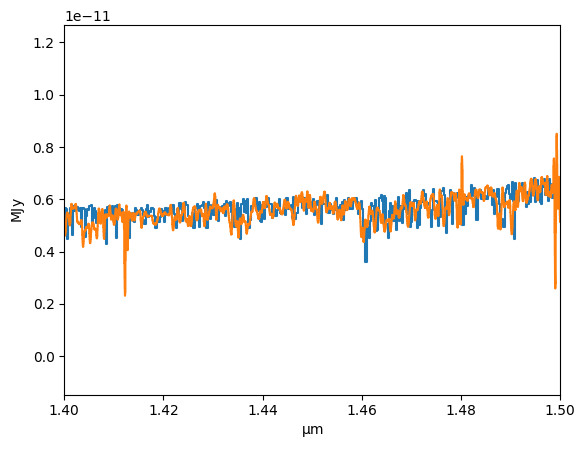

In [20]:
dlamb = np.diff(phoenix_spec.spectral_axis.bin_edges)
cumspec = np.cumsum(phoenix_spec.flux*dlamb).to(u.erg/u.s * u.cm**-2)

rescale_model = 3e-24
model_spec_flux = np.diff(np.interp(bins*u.micron, phoenix_spec.spectral_axis.to(u.micron), cumspec*rescale_model))/np.diff(bins*u.micron)
model_spec = specutils.Spectrum1D(spectral_axis=bins[:-1]*u.micron, flux=model_spec_flux)

plt.plot(model_spec.spectral_axis, model_spec.new_flux_unit(u.MJy).flux, ds='steps-mid')
plt.plot(interped_example_spec.spectral_axis, interped_example_spec.flux, ds='steps-mid')
plt.xlim(1.4, 1.5)

2023-02-27 16:12:26,011 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



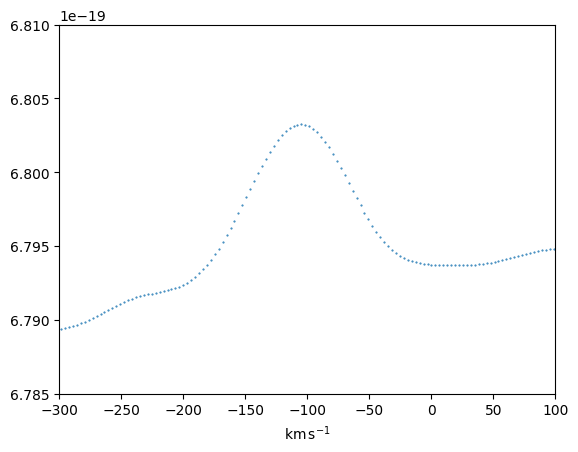

In [21]:
model_spec.uncertainty = StdDevUncertainty(np.ones(model_spec.flux.size)*model_spec.flux.unit)
interped_example_spec.uncertainty = StdDevUncertainty(np.ones(interped_example_spec.flux.size)*interped_example_spec.flux.unit)

corr, lags = specan.template_correlate(interped_example_spec, model_spec)
plt.plot(lags, corr.value,'.', ms=1)
plt.xlim(-300, 100)
plt.ylim(6.785e-19, 6.81e-19)
plt.savefig('example_vel_dist.png')

OK! So we have a spectrum that can be cross-correlated with the template to get a plausible answer. But now lets work out how to do the full model.  That then requires a PSF.

In [22]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

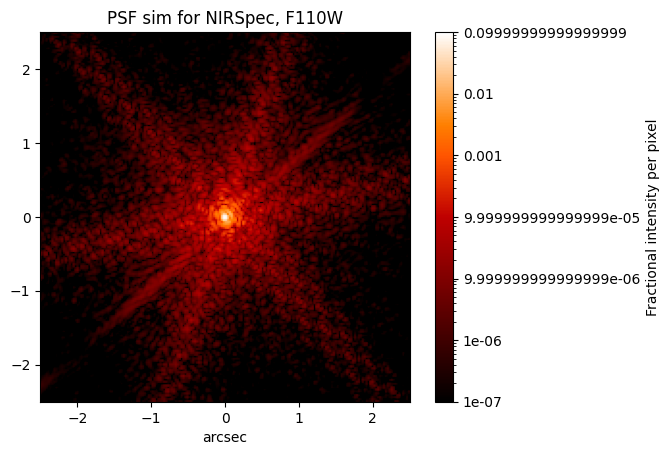

In [23]:
wns.image_mask = None
psf = wns.calc_psf(monochromatic=(1.6*u.micron).to(u.meter).value)
webbpsf.display_psf(psf)

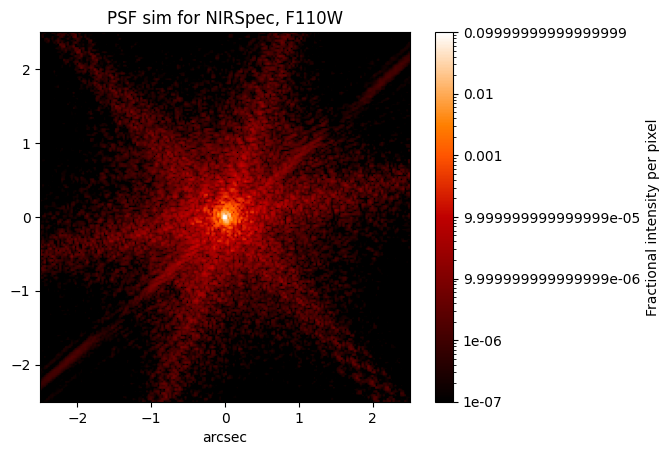

In [24]:
psf = wns.calc_psf(monochromatic=(1.2*u.micron).to(u.meter).value)
webbpsf.display_psf(psf)

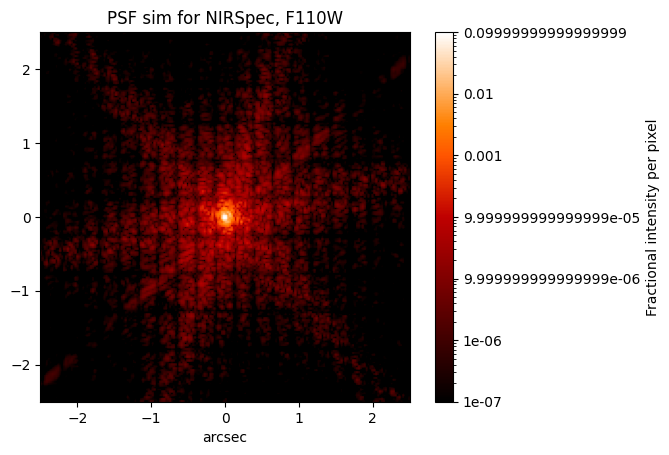

In [25]:
wns.image_mask = 'MSA all open'
psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value)
webbpsf.display_psf(psf)

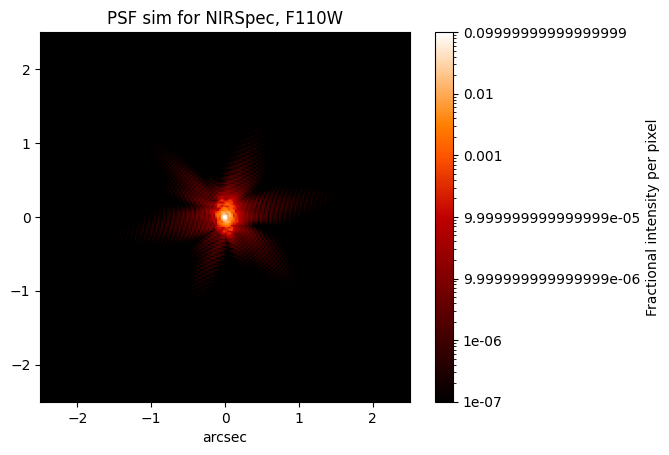

In [26]:
wns.image_mask = 'Single MSA open shutter'
psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value)
webbpsf.display_psf(psf)

Based on the above, a few simplifying assumptions:

* don't worry about where we are in the detector right now - it's a challenge to extract that simply from the WCS
* use a single monochromatic PSF at 1.4 micron
* Use a PSF for a single shutter with the star centered.  This is wrong, but need to add `shift_x`/`shift_y` at the Poppy level, and `webbpsf` doesn't natively support that.  Might be able to hack it later to neatly model the slit mis-centering, though.
* The spatial PSF variation is captured entirely in the vertical profile
* the LSF is entirely the horizontal profile

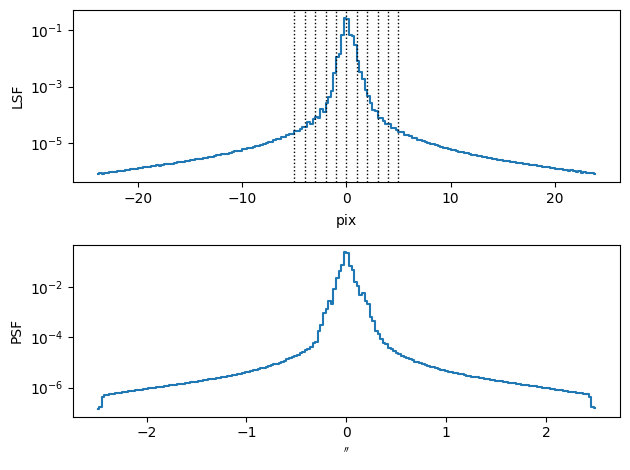

In [148]:
spsf = np.sum(psf['OVERDIST'].data, axis=1)
spsf_offsets = (np.arange(spsf.size) - (spsf.size-1)/2)*psf['OVERDIST'].header['PIXELSCL']*u.arcsec
lsf = np.sum(psf['OVERDIST'].data, axis=0)
lsf_offsets_px = (np.arange(lsf.size) - (lsf.size-1)/2)/4 * u.pixel

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.semilogy(lsf_offsets_px, lsf, ds='steps-mid')
ax1.set_ylabel('LSF')
for p in np.arange(11)-5:
    ax1.axvline(p, ls=':', lw=1,c='k')

ax2.semilogy(spsf_offsets, spsf, ds='steps-mid')
ax2.set_ylabel('PSF')
fig.tight_layout()

We will need to know the dispersion to know how to convolve the LSF with the model spectrum

In [28]:
dispersion_table = table.Table.read('https://jwst-docs.stsci.edu/files/97979440/97979446/1/1596073265458/jwst_nirspec_g140h_disp.fits', cache=True)
dispersion_table['WAVELENGTH'].unit = u.micron
dispersion_table['DLDS'].unit = u.micron/u.pixel
dispersion_table['R'].unit = u.dimensionless_unscaled
dispersion_table = table.QTable(dispersion_table)
dispersion_table

2023-02-27 16:12:51,235 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/core.py:2097: UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

2023-02-27 16:12:51,237 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/core.py:2097: UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warn

WAVELENGTH,DLDS,R
micron,micron / pix,
float32,float32,float32
0.5,0.00024101488816086203,942.9821166992188
0.5013999938964844,0.00024102148017846048,945.5966186523438
0.5027999877929688,0.00024102798488456756,948.2112426757812
0.5041999816894531,0.0002410344168310985,950.8261108398438
0.5055999755859375,0.00024104076146613806,953.441162109375
0.5070000290870667,0.00024104701878968626,956.056396484375
...,...,...
1.8930000066757202,0.00022585173428524286,3809.8203125


In [29]:
wls = np.quantile(example_slit.wavelength[np.isfinite(example_slit.wavelength)], [0, .5,1])*u.micron
dispers_spec = np.interp(wls, dispersion_table['WAVELENGTH'], dispersion_table['DLDS'])
dispers_spec

<Quantity [0.0002383 , 0.00023553, 0.0002318 ] micron / pix>

In [30]:
dispers_spec[0]/dispers_spec[-1]

<Quantity 1.02806596>

The dispersion varies by about 3% over the whole thing. Lets just try using the middle value for now and see where we get

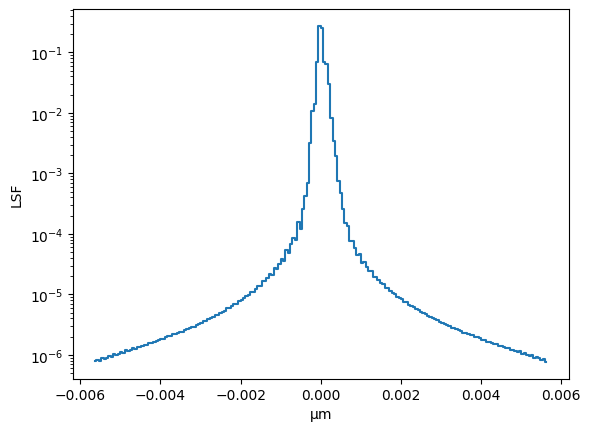

In [31]:
lsf_wl = lsf_offsets_px*dispers_spec[1]

plt.semilogy(lsf_wl, lsf, ds='steps-mid')
plt.ylabel('LSF');

See if we have a consistent dispersion across the model:

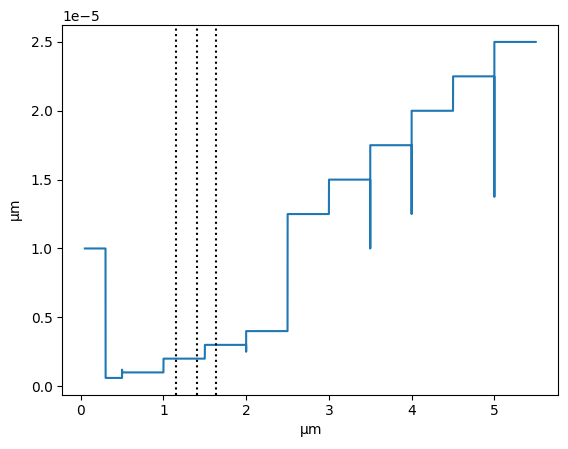

In [32]:
plt.plot(phoenix_spec.spectral_axis.to(u.micron), np.diff(phoenix_spec.spectral_axis.bin_edges).to(u.micron))
for wl in wls:
    plt.axvline(wl, ls=':', c='k')

Ugh, no, its split over two dispersions.  But they are both like 100x NIRSpec so it's not a huge deal.

At this point stuff gets a bit complex computationally.  How do we do the convolution properly? It should really be done at every wavelength value. But in maybe we can instead convolve by interpolating to the highest resolution, convolving, and then decimating back to the overasampled LSF sampling? (4x detector)

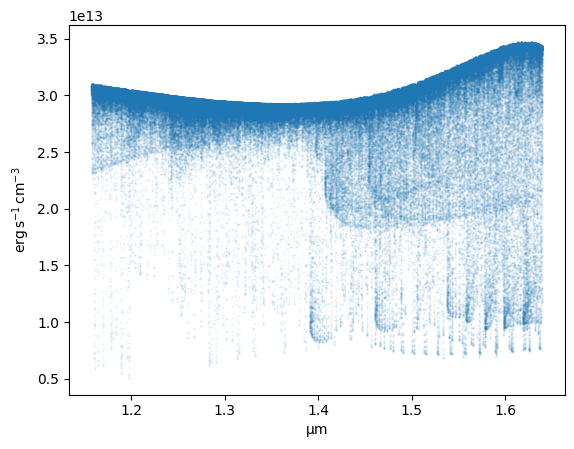

In [33]:
msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])
spacing = np.min(np.unique(np.diff(phoenix_spec.spectral_axis[msk])))

wl_grid = np.arange(wls[0].value, (wls[-1]+spacing.to(u.micron)).value, spacing.to(u.micron).value)*u.micron

phoenix_sub_spec = specutils.Spectrum1D(spectral_axis=wl_grid, flux=np.interp(wl_grid, phoenix_spec.spectral_axis, phoenix_spec.flux))
plt.plot(phoenix_sub_spec.spectral_axis, phoenix_sub_spec.flux, '.', ms=1, alpha=.1)

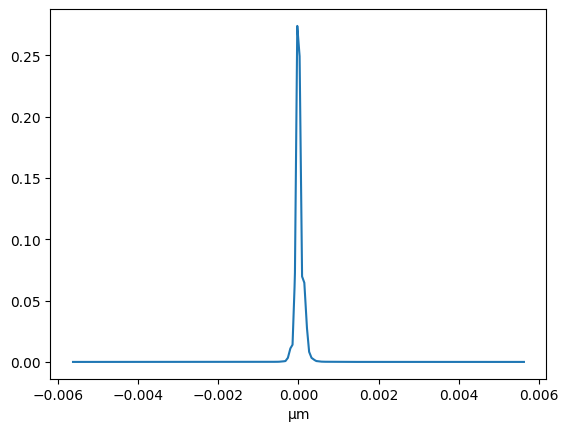

In [34]:
lsf_wl_gridsampled = np.arange(lsf_wl[0].value, (lsf_wl[-1]+spacing.to(u.micron)).value, spacing.to(u.micron).value)*u.micron
lsf_kernel = np.interp(lsf_wl_gridsampled, lsf_wl, lsf)
plt.plot(lsf_wl_gridsampled, lsf_kernel);

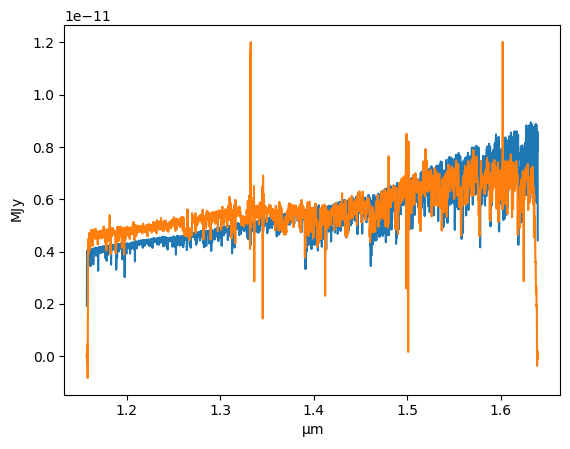

In [35]:
convolved_phoenix_flux = convolution.convolve_fft(phoenix_sub_spec.new_flux_unit(u.MJy).flux, lsf_kernel)
convolved_phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_sub_spec.spectral_axis, flux=convolved_phoenix_flux*rescale_model)

plt.plot(convolved_phoenix_spec.spectral_axis, convolved_phoenix_spec.flux)
plt.plot(interped_example_spec.spectral_axis, interped_example_spec.flux, ds='steps-mid')
ax = plt.gca()
fig = plt.gcf()

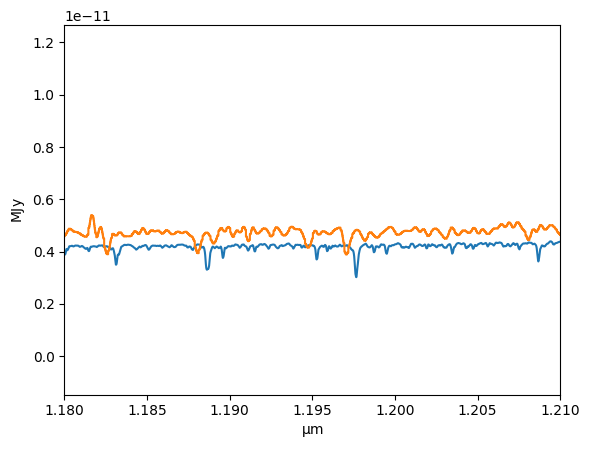

In [36]:
ax.set_xlim(1.18,1.21)
fig

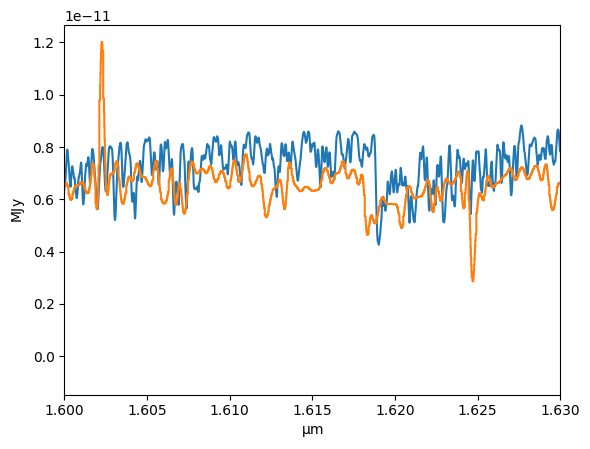

In [37]:
ax.set_xlim(1.6,1.63)
fig

Alright now to get the flux in a wavelength bin just integrate `convolved_phoenix_spec` 

In [52]:
yg, xg = np.meshgrid(*[np.arange(s) for s in example_slit.data.shape[::-1]])
data_coo, data_wl = example_slit.meta.wcs.pixel_to_world(yg, xg)
data_sep = slit_coo.separation(data_coo)

wcs_valid = np.isfinite(data_coo.ra)&np.isfinite(data_wl)

Problem with the above is: data_sep is not signed, so it doesn't capture the top-bottom asymmetry that the PSF may have.  Lets try to fix it up, but not I may easily have gotten lost with minus signs at this point so it should be double-checked.

In [39]:
sep_sign = 1 - (xg > np.nanargmin(data_sep, axis=0))*2
data_sep *= sep_sign

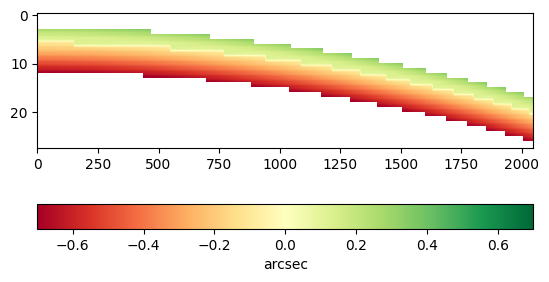

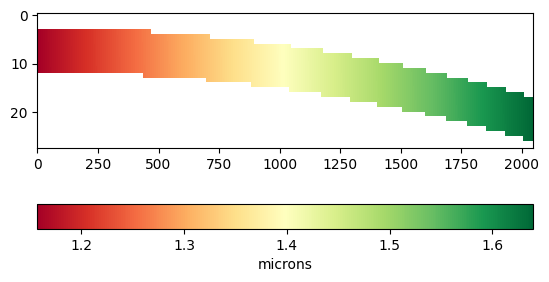

In [40]:
plt.imshow(data_sep.arcsec, aspect=20, cmap='RdYlGn',vmin=-.7, vmax=.7)
plt.colorbar(orientation='horizontal').set_label('arcsec')

plt.figure()
plt.imshow(data_wl.value, aspect=20, cmap='RdYlGn')
plt.colorbar(orientation='horizontal').set_label('microns')

That all looks right - lets compare the wavelength array to that of the wcs

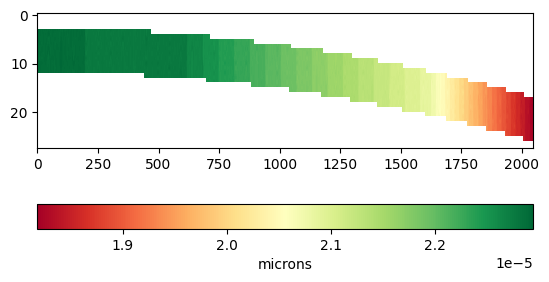

In [41]:
plt.figure()
plt.imshow(data_wl.value-example_slit.wavelength, aspect=20, cmap='RdYlGn')
plt.colorbar(orientation='horizontal').set_label('microns')

Uhm.  It's weird that they don't agree, but I guess it's weird at the $10^{-5}$ level so we shouldn't worry about it...

So lets trust the WCS.  Use the offset-from-source to produce a PSF map.  Not this does 

(<matplotlib.image.AxesImage at 0x7f1138a5de10>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f112ddd9150>)

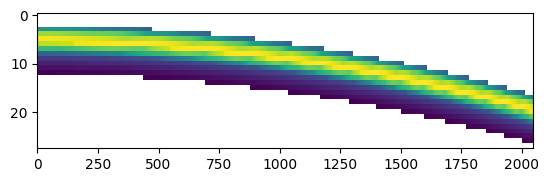

In [42]:
model_image = np.interp(data_sep, spsf_offsets, spsf)
visualization.imshow_norm(model_image, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         )

Sanity check: rescale to the data and just see how it looks

2.5077707520368274e-09

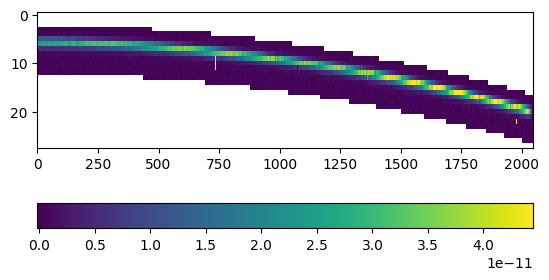

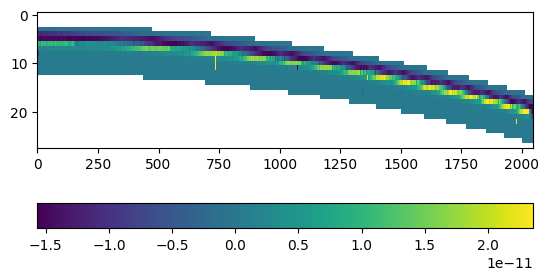

In [43]:
visualization.imshow_norm(example_slit.data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal')

model_rescale = np.nanquantile(example_slit.data, .9)/np.nanquantile(model_image, .9)

plt.figure()
visualization.imshow_norm(example_slit.data - model_image*model_rescale, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal')
model_rescale

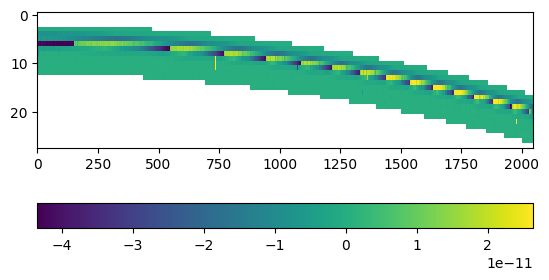

In [44]:
source_offset = .03*u.arcsec
model_image_off = np.interp(data_sep + source_offset, spsf_offsets, spsf)
model_rescale_off = np.nanquantile(example_slit.data, .99)/np.nanquantile(model_image, .99)

visualization.imshow_norm(example_slit.data - model_image_off*model_rescale_off, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal')

Looks like some sort of up-down offset might need to be included in the fit.  Or a better capturing of the PSF...

In [45]:
yg, xg = np.meshgrid(*[np.arange(s) for s in example_slit.data.shape[::-1]])
lower_wl = example_slit.meta.wcs.pixel_to_world(yg-.5, xg-.5)[1]
upper_wl = example_slit.meta.wcs.pixel_to_world(yg+.5, xg+.5)[1]

In [46]:
model_spectrum = np.ones_like(model_image)*np.nan
for i in tqdm(range(model_spectrum.shape[0])):
    for j in range(model_spectrum.shape[1]):
        lwl = lower_wl[i, j]
        upwl = upper_wl[i, j]
        if np.isfinite(lwl) and np.isfinite(upwl):
            msk = (lwl< phoenix_sub_spec.spectral_axis)&(phoenix_sub_spec.spectral_axis < upwl)
            model_spectrum[i, j] = integrate.simpson(phoenix_sub_spec.flux[msk], phoenix_sub_spec.spectral_axis[msk])

  0%|          | 0/28 [00:00<?, ?it/s]

(750.0, 1000.0)

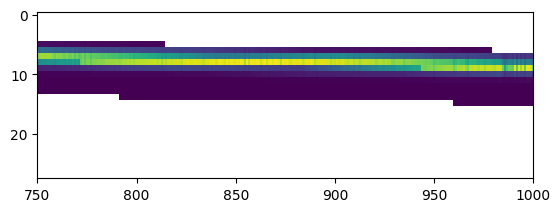

In [47]:
visualization.imshow_norm(model_spectrum*model_image, aspect=3,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest'
                         )
plt.xlim(750,1000)

Now we just need to fit the above into an optimizer...

In [48]:
import emcee

In [81]:
MINF = -np.inf

class SlitProbModel:
    param_names = ['spatial_offset_arcsec','v_kms', 'spec_to_model_normalization']
    
    def __init__(self, slitdatanode, model_1d_spectrum):
        self._cached_model = None
        self.slitdata_node = slitdatanode
        self.model_1d_spectrum = model_1d_spectrum
        
        self.spatial_offset_arcsec = 0
        self.v_kms = 0
        self.spec_to_model_normalization = 1
        
        self.sm_ratio_pri_bounds = (0.5, 1.5)
    
    def update_params(self, params):
        self._cached_model = None
        
        if len(params) != len(self.param_names):
            raise ValueError('params does not match param_names!')
            
        for nm, p in zip(self.param_names, params):
            setattr(self, nm, p)
            
    @property
    def slitdata_node(self):
        return self._slitdata_node
    
    @slitdata_node.setter
    def slitdata_node(self, val):
        self._slitdata_node = val
        self._notnan_mask = ~np.isnan(val.data)
        self._err_mask = val.err>0
        self._data_mask = self._notnan_mask & self._err_mask
        
        self._masked_data = val.data[self._data_mask]
        self._masked_err = val.err[self._data_mask]
        
        self._loglike_norm = -0.5*np.log(2*np.pi) - np.log(self._masked_err)
        self._cached_model = None
            
    @property
    def model_1d_spectrum(self):
        return self._model_1d_spectrum
    
    @model_1d_spectrum.setter
    def model_1d_spectrum(self, val):
        self._model_1d_spectrum = val
        self._cached_model = None

    def make_model_spectrum(self, show_integration_progress=True):
        if self._cached_model is None:
            yg, xg = np.meshgrid(*[np.arange(s) for s in self.slitdata_node.data.shape[::-1]])
            data_coo, data_wl = self.slitdata_node.meta.wcs.pixel_to_world(yg, xg)
            data_sep = slit_coo.separation(data_coo)

            wcs_valid = np.isfinite(data_coo.ra)&np.isfinite(data_wl)

            sep_sign = 1 - (xg > np.nanargmin(data_sep, axis=0))*2
            data_sep *= sep_sign

            model_image = np.interp(data_sep + self.spatial_offset_arcsec*u.arcsec, 
                                    spsf_offsets, spsf)

            model_spectrum_im = np.ones_like(model_image)*np.nan
            if show_integration_progress:
                progress = tqdm
            else:
                progress = lambda x:x

            dlolp1 = self.v_kms/constants.c.to(u.km/u.s).value + 1

            lower_wl = self.slitdata_node.meta.wcs.pixel_to_world(yg-.5, xg-.5)[1] * dlolp1
            upper_wl = self.slitdata_node.meta.wcs.pixel_to_world(yg+.5, xg+.5)[1] * dlolp1

            for i in progress(range(model_spectrum_im.shape[0])):
                for j in range(model_spectrum_im.shape[1]):
                    lwl = lower_wl[i, j]
                    upwl = upper_wl[i, j]
                    if np.isfinite(lwl) and np.isfinite(upwl):
                        msk = (lwl< self.model_1d_spectrum.spectral_axis)&(self.model_1d_spectrum.spectral_axis < upwl)
                        model_spectrum_im[i, j] = integrate.simpson(self.model_1d_spectrum.flux[msk], self.model_1d_spectrum.spectral_axis[msk])

            self._cached_model = model_spectrum_im * model_image * self.spec_to_model_normalization
        return self._cached_model
    
    def _imshow_something(self, something, **plotkwargs):
        plotkwargs.setdefault('aspect', something.shape[1]/something.shape[0]/3)
        plotkwargs.setdefault('interval', visualization.PercentileInterval(99))
        plotkwargs.setdefault('stretch', visualization.LinearStretch())
        plotkwargs.setdefault('interpolation', 'nearest')
        
        return visualization.imshow_norm(something, **plotkwargs)
    
    def imshow_model(self, **plotkwargs):
        return self._imshow_something(self.make_model_spectrum())
    
    def imshow_data(self, **plotkwargs):
        return self._imshow_something(self.slitdata_node.data)
    
    def imshow_residual(self, **plotkwargs):
        return self._imshow_something(self.slitdata_node.data - self.make_model_spectrum())
        
    def log_prior(self):
        if self.spatial_offset_arcsec*self.spatial_offset_arcsec > 1:
            return MINF
        if self.v_kms > 1000 or self.v_kms < -100:
            return MINF
        if self.spec_to_model_normalization > self.sm_ratio_pri_bounds[1] or self.spec_to_model_normalization < self.sm_ratio_pri_bounds[0]:
            return MINF
        return 0

    def log_likelihood(self):
        model = self.make_model_spectrum(show_integration_progress=False)
        
        d = model[self._data_mask] - self.slitdata_node.data[self._data_mask]        
        return self._loglike_norm + -0.5*(d/example_slit.err[self._data_mask])**2

    def log_prob(self, params):
        self.update_params(params)
        
        lpri = self.log_prior()
        if lpri == MINF:
            return MINF

        return np.nansum(lpri + self.log_likelihood())
    
    def make_sampler_and_inits(self, nwalkers, stds, **kwargs):
        sampler = emcee.EnsembleSampler(nwalkers, len(self.param_names), self.log_prob, **kwargs)
        
        try:
            stds = float(stds)
        except TypeError:
            pass
        else:
            stds = [stds for _ in range(len(self.param_names))]
            
        state0 = emcee.utils.sample_ball([getattr(self, nm) for nm in self.param_names], 
                                         stds, 
                                         nwalkers)
        
        return sampler, state0
    
    def make_and_run_sampler(self, nwalkers, stds, nsteps, **kwargs):
        prog = kwargs.pop('progress', None)
        sampler, state0 = self.make_sampler_and_inits(nwalkers, stds, **kwargs)
        sampler.run_mcmc(state0, nsteps, progress=prog)
        return sampler
    

spm = SlitProbModel(example_slit, model_1d_spectrum=phoenix_sub_spec)

  0%|          | 0/28 [00:00<?, ?it/s]

60898803.92202546 2.4338196909223797e-11


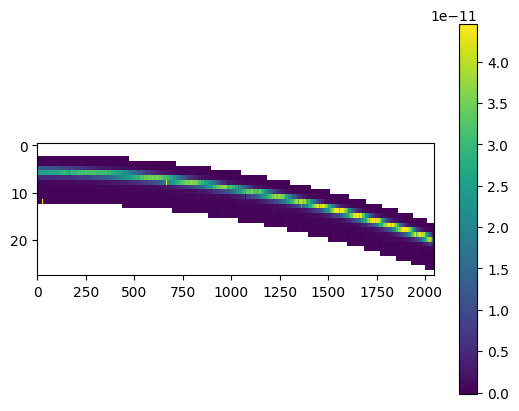

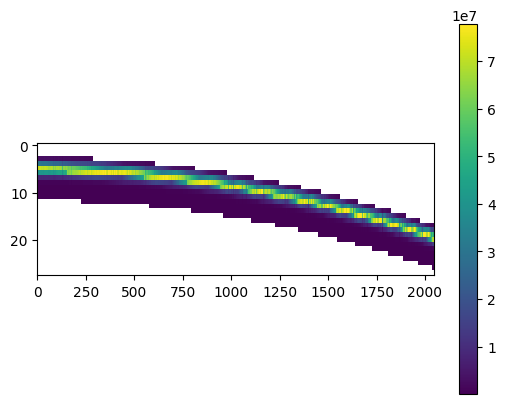

In [82]:
plt.figure()
spm.imshow_data()
plt.colorbar()

plt.figure()
spm.imshow_model()
plt.colorbar()

print(np.nanquantile(spm.make_model_spectrum(), .9),np.nanquantile(spm.slitdata_node.data, .9))
sm_ratio = np.nanquantile(spm.slitdata_node.data, .9)/np.nanquantile(spm.make_model_spectrum(), .9)
spm.sm_ratio_pri_bounds = (sm_ratio/2, sm_ratio*2)

  0%|          | 0/28 [00:00<?, ?it/s]

(-10329722.720151393, 18635)

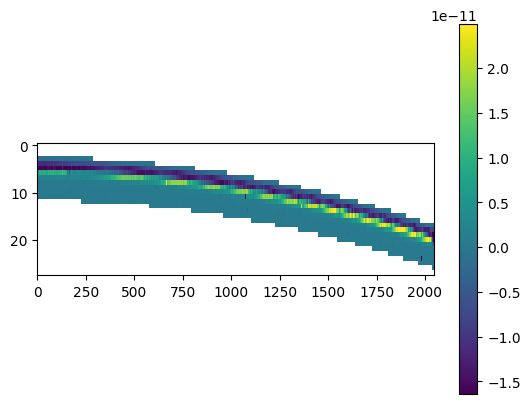

In [51]:
spm.update_params([0, 0, sm_ratio])

spm.imshow_residual()
plt.colorbar()
np.nansum(spm.log_likelihood()), np.sum(np.isfinite(spm.log_likelihood()))

  0%|          | 0/28 [00:00<?, ?it/s]

(-3698730.082675931, 18635)

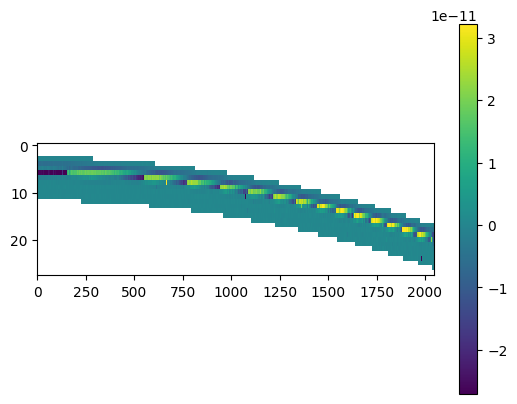

In [255]:
spm.update_params([0.03, 10, sm_ratio])

spm.imshow_residual()
plt.colorbar()
np.nansum(spm.log_likelihood()), np.sum(np.isfinite(spm.log_likelihood()))

In [259]:
%%time

sampler = spm.make_and_run_sampler(10, [1e-3, 1e-3, spm.spec_to_model_normalization*1e-3], 10, progress=True)

100%|███████████████████████████████████████████| 10/10 [08:37<00:00, 51.74s/it]

CPU times: user 9min 27s, sys: 591 ms, total: 9min 28s
Wall time: 9min 28s


About a min per step, apparently. Hard to sample without some optimization.

As a quicker rough estimate, lets try a grid:

In [266]:
sm_ratio

3.9964983450884045e-19

In [275]:
sos, vs = np.mgrid[.02:.04:10j, 0:200:10j]
sos = sos.ravel()
vs = vs.ravel()
lls = []
for so, v in tqdm(list(zip(sos, vs))):
    spm.update_params([so, v, sm_ratio])
    lls.append(spm.log_likelihood())
lls = np.array(lls)

  0%|          | 0/100 [00:00<?, ?it/s]

IndexError: index -1 is out of bounds for axis 0 with size 0

Oops, that won't work :( probably a sign that the model is too short.  Extend it a bit:

In [83]:
vrangeoverc = (2000*u.km/u.s)/constants.c
lower_wl = wls[0]*(1 - vrangeoverc) 
upper_wl = wls[-1]*(1 + vrangeoverc)

msk = (lower_wl <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=upper_wl)
spacing = np.min(np.unique(np.diff(phoenix_spec.spectral_axis[msk])))

wl_grid = np.arange(lower_wl.value, (upper_wl+spacing.to(u.micron)).value, spacing.to(u.micron).value)*u.micron

phoenix_sub_spec_wider = specutils.Spectrum1D(spectral_axis=wl_grid, flux=np.interp(wl_grid, phoenix_spec.spectral_axis, phoenix_spec.flux))

convolved_wider_spec = specutils.Spectrum1D(spectral_axis=phoenix_sub_spec_wider.spectral_axis, 
                                            flux=convolution.convolve_fft(phoenix_sub_spec_wider.new_flux_unit(u.MJy).flux, lsf_kernel))


spm2 = SlitProbModel(example_slit, model_1d_spectrum=convolved_wider_spec)

Now also to not wait forever, lets just do a purely velocity-scan with the above estimate of the offset.

  0%|          | 0/25 [00:00<?, ?it/s]

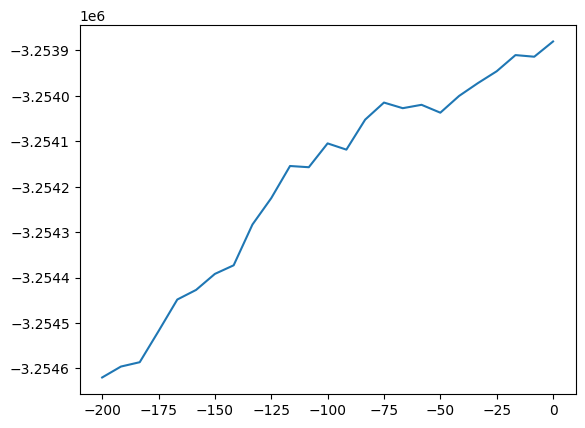

In [127]:
vs = np.linspace(-200, 0, 25)
lls = []
for v in tqdm(vs):
    spm2.update_params([.03, v, sm_ratio])
    lls.append(spm2.log_likelihood())
lls = np.array(lls)
plt.plot(vs, np.nansum(lls, axis=1))

  0%|          | 0/25 [00:00<?, ?it/s]

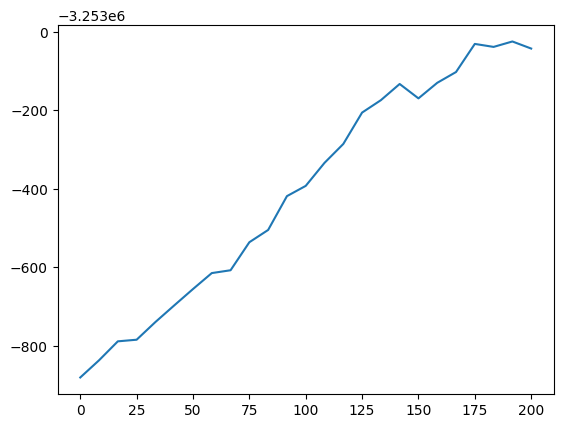

In [130]:
vs = np.linspace(0, 200, 25)
lls = []
for v in tqdm(vs):
    spm2.update_params([.03, v, sm_ratio])
    lls.append(spm2.log_likelihood())
lls = np.array(lls)
plt.plot(vs, np.nansum(lls, axis=1))

  0%|          | 0/25 [00:00<?, ?it/s]

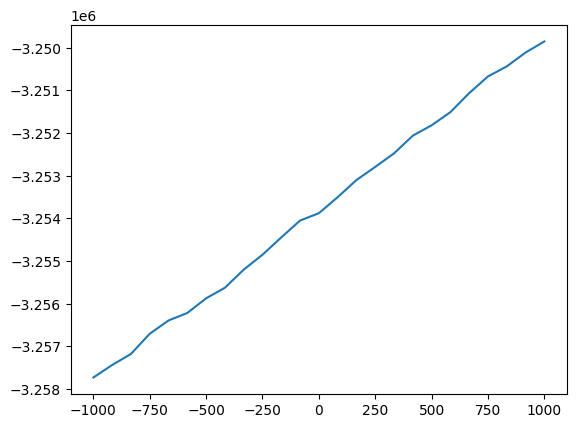

In [146]:
vs = np.linspace(-1000, 1000, 25)
lls = []
for v in tqdm(vs):
    spm2.update_params([.03, v, sm_ratio])
    lls.append(spm2.log_likelihood())
lls = np.array(lls)
plt.plot(vs, np.nansum(lls, axis=1))

In [149]:
sos, vs = np.mgrid[.02:.04:10j, -150:-50:11j]
lls = []
for so, v in tqdm(list(zip(sos.ravel(), vs.ravel()))):
    spm2.update_params([so, v, sm_ratio])
    lls.append(spm2.log_likelihood())
lls = np.array(lls)

  0%|          | 0/110 [00:00<?, ?it/s]

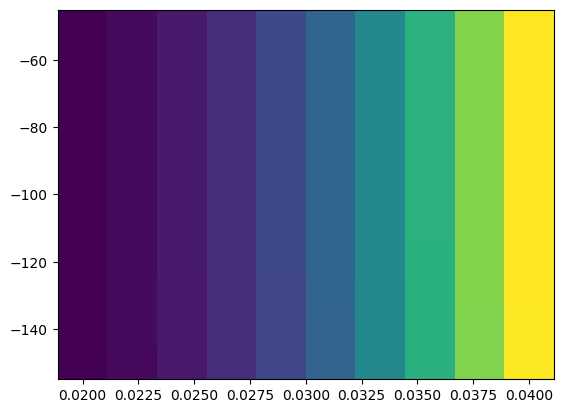

In [150]:
llss = np.nansum(lls, axis=1)

plt.pcolormesh(sos, vs, llss.reshape(sos.shape))

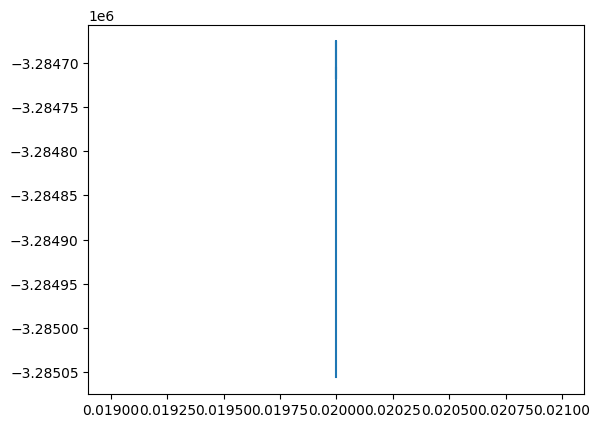

In [174]:
plt.plot(sos[0], llss.reshape(sos.shape)[0])

  0%|          | 0/25 [00:00<?, ?it/s]

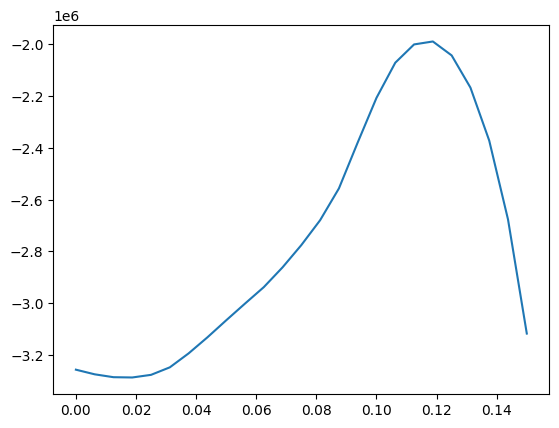

In [175]:
sos = np.linspace(0, .15, 25)
lls = []
for so in tqdm(sos):
    spm2.update_params([so, -100, sm_ratio])
    lls.append(spm2.log_likelihood())
lls = np.array(lls)
plt.plot(sos, np.nansum(lls, axis=1))

This is confusing but maybe at least partially sensible.  Upshot: need to dramatically speed up the spectral interpolation somehow.  Cannon or Payne?

In [154]:
example_slit.data.shape

(28, 2048)

In [169]:
rand_x = np.random.rand(20480*280)*2048
rand_y = np.random.rand(20480*280)*28
rand_px = np.random.randn(20480*280)
%timeit np.histogram2d(rand_x, rand_y, weights=rand_px, bins=(28,2048))

711 ms ± 77.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
